# Preprocess Continuous Data - Resting State
## MS012

10/03/2023
Updated: 02/26/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
subj_id = 'MS012'

# Specify root directory for data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/resting_state_proj/resting_state_ieeg/'
anat_dir = f'{base_dir}anat'
neural_dir = f'{base_dir}preprocess/raw_data/{subj_id}'
save_dir = f'{base_dir}preprocess/clean_data/{subj_id}'
os.makedirs(save_dir,exist_ok = True)

#### Import Data

In [30]:
edf_files = glob(f'{neural_dir}/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)
mne_data

<RawEDF | MS012_Resting_iEEG.edf, 276 x 634048 (619.2 s), ~1.30 GB, data loaded>

In [31]:
mne_data.ch_names

['RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'RmOlF10',
 'RmOlF11',
 'RmOlF12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'RmCmS9',
 'RmCmS10',
 'RalS1',
 'RalS2',
 'RalS3',
 'RalS4',
 'RalS5',
 'RalS6',
 'RalS7',
 'RalS8',
 'RalS9',
 'RalS10',
 'RalS11',
 'RalS12',
 'RalS13',
 'RalS14',
 'RmlS1',
 'RmlS2',
 'RmlS3',
 'RmlS4',
 'RmlS5',
 'RmlS6',
 'RmlS7',
 'RmlS8',
 'RmlS9',
 'RmlS10',
 'RmlS11',
 'RmlS12',
 'RplS11',
 'RplS12',
 'RplS13',
 'RplS14',
 'RplS15',
 'RplS16',
 'RplS17',
 'RplS18',
 'RplS19',
 'RplS110',
 'RplS111',
 'RplS112',
 'RplS113',
 'RplS114',
 'RplS115',
 'RplS116',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6',
 'RAglT7',
 'RAglT8',
 'RAglT9',
 'RAglT10',
 'RHplT1',
 'RHplT2',
 'RHplT3',
 'RHplT4',
 'RHplT5',
 'RHplT6',
 'RHplT7',
 'RH

# Import Anat Recon Info - check all elecs are present in data + recon sheet


In [32]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]
elec_locs = elec_locs.dropna(axis=0, how = 'all')
elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,RaCaS1,A24rv_R,2.213847,40.555422,-7.592365,4.000299,31.589838,-7.086648,Gray,Right ACgG anterior cingulate gyrus,Area s24,R ACC,R CG,Right cingulate gyrus D,NaN,NaN
1,RaCaS10,A9l_R,12.608599,57.336974,29.969887,15.494926,46.622420,42.064551,Gray,Right SFG superior frontal gyrus,Unknown,R Superior Frontal Gyrus,R SFG,Right superior frontal gyrus 2 C,NaN,NaN
2,RaCaS2,A24rv_R,3.413242,42.153665,-3.596380,5.193647,33.135858,-1.753866,Gray,Right ACgG anterior cingulate gyrus,Area 33,R ACC,R CG,Right cingulate gyrus D,NaN,NaN
3,RaCaS3,A24rv_R,4.612636,43.352347,1.198800,6.248130,34.246815,4.546188,Gray,Right ACgG anterior cingulate gyrus,Area 33,R ACC,R CG,Right cingulate gyrus E,NaN,NaN
4,RaCaS4,A24rv_R,5.812031,44.950590,5.594383,7.611961,35.782938,10.284493,Gray,Right ACgG anterior cingulate gyrus,Area 33,R ACC,R CG,Right cingulate gyrus F,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,RplS15,G_R,30.999314,-6.992307,3.596391,35.220487,-20.101441,1.856086,Gray,Right PIns posterior insula,Area Ig1,R Insula Lobe,R INS,Right posterior long insular gyrus B,NaN,NaN
100,RplS16,G_R,30.599516,-10.987915,7.192777,34.940151,-24.533599,5.788729,Gray,Right PP planum polare,Area Ig1,Unknown,R INS,Right posterior long insular gyrus A,NaN,NaN
101,RplS17,Unknown,30.199718,-14.983522,10.789163,34.688592,-29.067621,9.718461,White,Right Cerebral White Matter,Area TE 11,R Superior Temporal Gyrus,Unknown,Right superior temporal gyrus E,WM,NaN
102,RplS18,Unknown,29.799920,-18.979129,14.385548,34.226653,-33.595343,13.608131,White,Right Cerebral White Matter,Area TE 11,Unknown,Unknown,Right superior temporal gyrus F,WM,NaN


### Fix edf channel names

In [33]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [34]:
unmatched_names

[]

In [35]:
unmatched_seeg

[]

In [36]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}
new_name_dict

{'RmOlF1': 'rmolf1',
 'RmOlF2': 'rmolf2',
 'RmOlF3': 'rmolf3',
 'RmOlF4': 'rmolf4',
 'RmOlF5': 'rmolf5',
 'RmOlF6': 'rmolf6',
 'RmOlF7': 'rmolf7',
 'RmOlF8': 'rmolf8',
 'RmOlF9': 'rmolf9',
 'RmOlF10': 'rmolf10',
 'RmOlF11': 'rmolf11',
 'RmOlF12': 'rmolf12',
 'RaCaS1': 'racas1',
 'RaCaS2': 'racas2',
 'RaCaS3': 'racas3',
 'RaCaS4': 'racas4',
 'RaCaS5': 'racas5',
 'RaCaS6': 'racas6',
 'RaCaS7': 'racas7',
 'RaCaS8': 'racas8',
 'RaCaS9': 'racas9',
 'RaCaS10': 'racas10',
 'RmCmS1': 'rmcms1',
 'RmCmS2': 'rmcms2',
 'RmCmS3': 'rmcms3',
 'RmCmS4': 'rmcms4',
 'RmCmS5': 'rmcms5',
 'RmCmS6': 'rmcms6',
 'RmCmS7': 'rmcms7',
 'RmCmS8': 'rmcms8',
 'RmCmS9': 'rmcms9',
 'RmCmS10': 'rmcms10',
 'RalS1': 'rals1',
 'RalS2': 'rals2',
 'RalS3': 'rals3',
 'RalS4': 'rals4',
 'RalS5': 'rals5',
 'RalS6': 'rals6',
 'RalS7': 'rals7',
 'RalS8': 'rals8',
 'RalS9': 'rals9',
 'RalS10': 'rals10',
 'RalS11': 'rals11',
 'RalS12': 'rals12',
 'RalS13': 'rals13',
 'RalS14': 'rals14',
 'RmlS1': 'rmls1',
 'RmlS2': 'rmls2',
 'Rm

In [37]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS012_Resting_iEEG.edf, 276 x 634048 (619.2 s), ~1.30 GB, data loaded>

In [38]:
mne_data.ch_names

['rmolf1',
 'rmolf2',
 'rmolf3',
 'rmolf4',
 'rmolf5',
 'rmolf6',
 'rmolf7',
 'rmolf8',
 'rmolf9',
 'rmolf10',
 'rmolf11',
 'rmolf12',
 'racas1',
 'racas2',
 'racas3',
 'racas4',
 'racas5',
 'racas6',
 'racas7',
 'racas8',
 'racas9',
 'racas10',
 'rmcms1',
 'rmcms2',
 'rmcms3',
 'rmcms4',
 'rmcms5',
 'rmcms6',
 'rmcms7',
 'rmcms8',
 'rmcms9',
 'rmcms10',
 'rals1',
 'rals2',
 'rals3',
 'rals4',
 'rals5',
 'rals6',
 'rals7',
 'rals8',
 'rals9',
 'rals10',
 'rals11',
 'rals12',
 'rals13',
 'rals14',
 'rmls1',
 'rmls2',
 'rmls3',
 'rmls4',
 'rmls5',
 'rmls6',
 'rmls7',
 'rmls8',
 'rmls9',
 'rmls10',
 'rmls11',
 'rmls12',
 'rpls11',
 'rpls12',
 'rpls13',
 'rpls14',
 'rpls15',
 'rpls16',
 'rpls17',
 'rpls18',
 'rpls19',
 'rpls110',
 'rpls111',
 'rpls112',
 'rpls113',
 'rpls114',
 'rpls115',
 'rpls116',
 'raglt1',
 'raglt2',
 'raglt3',
 'raglt4',
 'raglt5',
 'raglt6',
 'raglt7',
 'raglt8',
 'raglt9',
 'raglt10',
 'rhplt1',
 'rhplt2',
 'rhplt3',
 'rhplt4',
 'rhplt5',
 'rhplt6',
 'rhplt7',
 'rh

In [39]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) 
#print extra channels in mne_data.ch_names and make sure none of them are neural channels


['fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'chest1', 'chest2', 'abd1', 'abd2', 'c130', 'c131', 'c132', 'c133', 'c134', 'c135', 'c136', 'c137', 'c138', 'c139', 'c140', 'c141', 'c142', 'c143', 'c144', 'c145', 'c146', 'c147', 'c148', 'c149', 'c150', 'c151', 'c152', 'c153', 'c154', 'c155', 'c156', 'c157', 'c158', 'c159', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233',

In [40]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 0 left & 105 right sEEG electrodes
We have a total of 105 sEEG electrodes


In [41]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names)) # it is either called DC1 or research
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 


<RawEDF | MS012_Resting_iEEG.edf, 105 x 634048 (619.2 s), ~508.0 MB, data loaded>

In [42]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS012_Resting_iEEG.edf, 105 x 634048 (619.2 s), ~508.0 MB, data loaded>

In [43]:
mne_data.drop_channels(['research'])

<RawEDF | MS012_Resting_iEEG.edf, 104 x 634048 (619.2 s), ~503.2 MB, data loaded>

In [44]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS012_Resting_iEEG.edf, 104 x 634048 (619.2 s), ~503.2 MB, data loaded>

### Notch filter line noise

In [45]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:    1.4s finished


<RawEDF | MS012_Resting_iEEG.edf, 104 x 634048 (619.2 s), ~503.2 MB, data loaded>

### Resampling data 

In [46]:
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    3.1s finished


<RawEDF | MS012_Resting_iEEG.edf, 104 x 309594 (619.2 s), ~245.8 MB, data loaded>

### Bad Channel Removal (manual)

Let's pick out any bad channels missed by automatic screening (visual inspection as a reference), or restore channels that were erroneously deemed bad. You have to press the "power" button twice (once for the plot and once for the panel beneath it) when you're done so that you're manual changes are saved.

In [5]:
mne_data = mne.io.read_raw_fif(f'{save_dir}/{subj_id}_raw_ieeg.fif', preload=True)

<IPython.core.display.Javascript object>


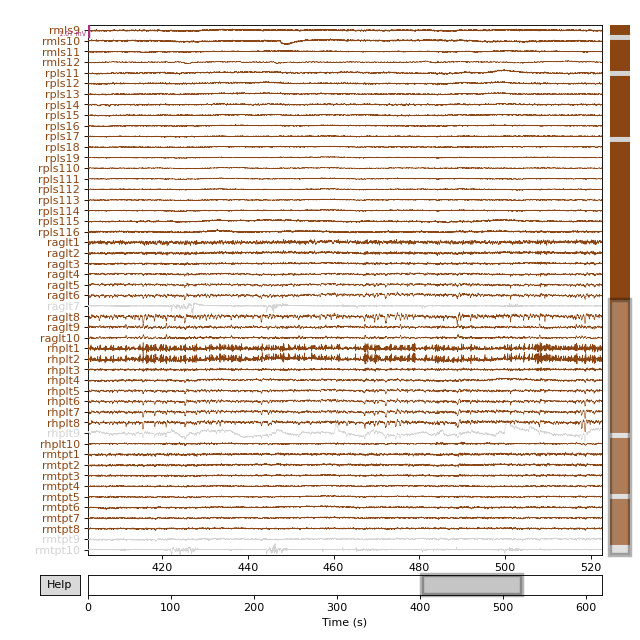

<IPython.core.display.Javascript object>


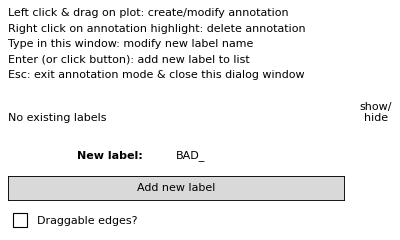

In [6]:
%matplotlib notebook

fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a') #lots of bad times 

In [7]:
mne_data.info['bads'] #sanity check that bads info saved


['raglt7', 'rmcms1', 'rmolf10', 'rmolf3', 'rmtpt10', 'rmtpt9', 'rhplt9']

## Save raw LFP data
Notch filtered and resampled with bad elecs indicated

In [8]:
mne_data.save(f'{save_dir}/{subj_id}_raw_ieeg.fif',overwrite=True)

# Rereference data 

To start annotating, press 'Add new label' in the bottom panel. Then left click and drag around window of interest. 

In [10]:
# Re-reference neural data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]

mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

<IPython.core.display.Javascript object>


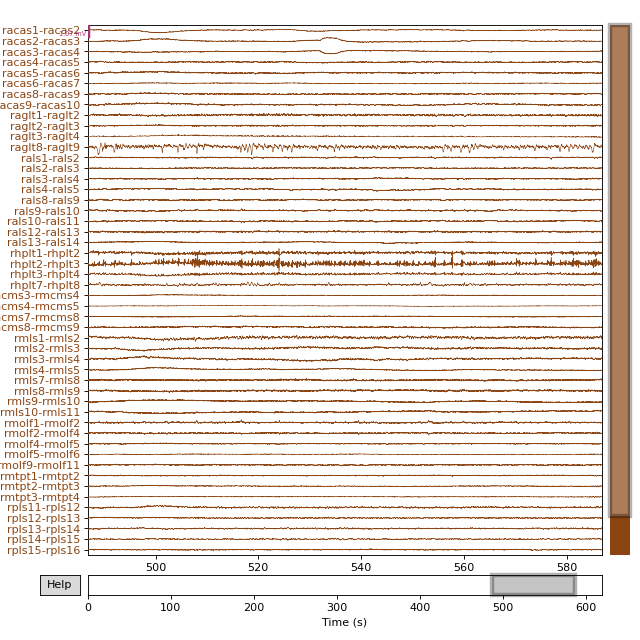

<IPython.core.display.Javascript object>


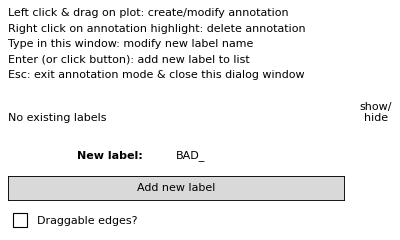

In [11]:
%matplotlib notebook

fig = mne_data_bp_reref.plot(start=2, duration=100, n_channels=50,scalings=mne_data._data.max()/20 ) # plot all channels at once
fig.fake_keypress("a")


<IPython.core.display.Javascript object>


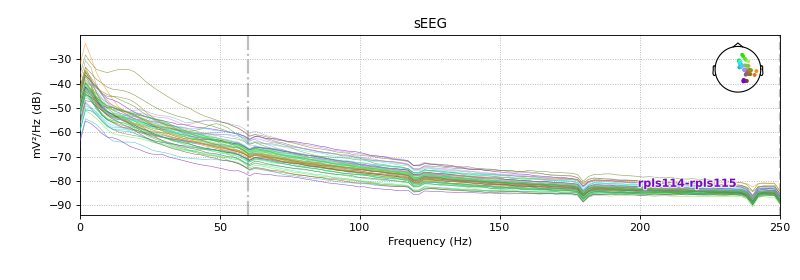

<IPython.core.display.Javascript object>


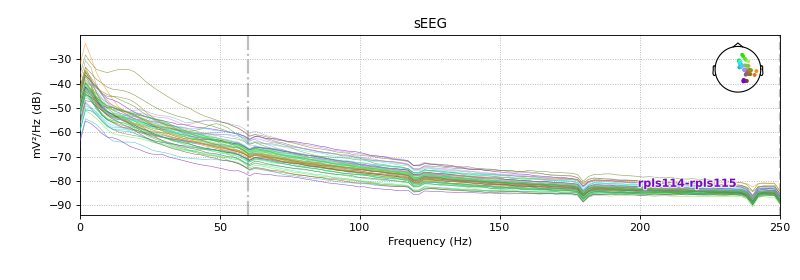

In [12]:
mne_data_bp_reref.compute_psd().plot()

### Save reref data

In [13]:
mne_data_bp_reref.save(f'{save_dir}/{subj_id}_bp_ref_ieeg.fif',overwrite=True)